# Recurrent Neural Network


::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

국가명에 따라 이름을 생성하는 RNN모델을 학습시켜보기. 카테고리를 입력하고 한 번에 하나의 글자를 출력합니다. 이런 모델링은 이전에 배웠던 'language modeling'과 같은 원리

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
# DATAPATH = 'YOUR DATA PATH'
DATAPATH = '/content/drive/MyDrive/DWU_SpecialLecture/data'

## Data preparation

In [ ]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles(f'{DATAPATH}/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Dutch', 'Italian', 'Arabic', 'Chinese', 'Scottish', 'Spanish', 'Portuguese', 'Irish', 'English', 'German', 'Czech', 'Greek', 'Japanese', 'French', 'Polish', 'Russian', 'Vietnamese', 'Korean']
O'Neal


## Models

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Training

### Helper fucntions

In [ ]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### Training code

In [ ]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
randomTrainingExample()[0].shape, randomTrainingExample()[1].shape, randomTrainingExample()[2]

(torch.Size([1, 18]),
 torch.Size([8, 1, 59]),
 tensor([20,  4, 13, 19,  4, 18, 58]))

In [ ]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100
print_every = 50
plot_every = 50
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 0s (50 50%) 4.0289
0m 0s (100 100%) 3.9971


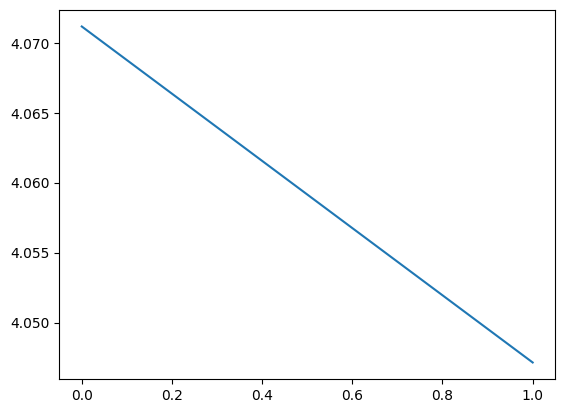

In [ ]:

import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

RrrrrNrNr
U
SNr
GrBBrBBBBBBBBBBBBBBBB
EbBrBBBBBBBrBBBBBBBBB
RrBrBBBBBBBBBBBBBrBrB
SNssssssskNssssssssss
PNsssssssssskNssssssk
AgJssssssssssssssskNs
Cror
H
Iror


# Attention

In [ ]:
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

import torch
import math

In [ ]:

x = torch.tensor([
  [1.0, 0.0, 1.0, 0.0],
  [0.0, 2.0, 0.0, 2.0],
  [1.0, 1.0, 1.0, 1.0],
])
w_query = torch.tensor([
  [1.0, 0.0, 1.0],
  [1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0],
  [0.0, 1.0, 1.0]
])
w_key = torch.tensor([
  [0.0, 0.0, 1.0],
  [1.0, 1.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 1.0, 0.0]
])
w_value = torch.tensor([
  [0.0, 2.0, 0.0],
  [0.0, 3.0, 0.0],
  [1.0, 0.0, 3.0],
  [1.0, 1.0, 0.0]
])

In [ ]:
keys = torch.matmul(x, w_key)
querys = torch.matmul(x, w_query)
values = torch.matmul(x, w_value)

In [ ]:
attn_scores = torch.matmul(querys, keys.T)
attn_scores

tensor([[ 2.,  4.,  4.],
        [ 4., 16., 12.],
        [ 4., 12., 10.]])

In [ ]:
import numpy as np
from torch.nn.functional import softmax
key_dim_sqrt = np.sqrt(keys.shape[-1])
attn_scores_softmax = softmax(attn_scores / key_dim_sqrt, dim=-1)
attn_scores_softmax

tensor([[1.3613e-01, 4.3194e-01, 4.3194e-01],
        [8.9045e-04, 9.0884e-01, 9.0267e-02],
        [7.4449e-03, 7.5471e-01, 2.3785e-01]])

In [ ]:
weighted_values = torch.matmul(attn_scores_softmax, values)
weighted_values

tensor([[1.8639, 6.3194, 1.7042],
        [1.9991, 7.8141, 0.2735],
        [1.9926, 7.4796, 0.7359]])

# Seq2Seq


In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .


## Data preparation

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(f'{DATAPATH}/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
import re
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['tu n es pas invite', 'you aren t invited']


## Seq2Seq Model

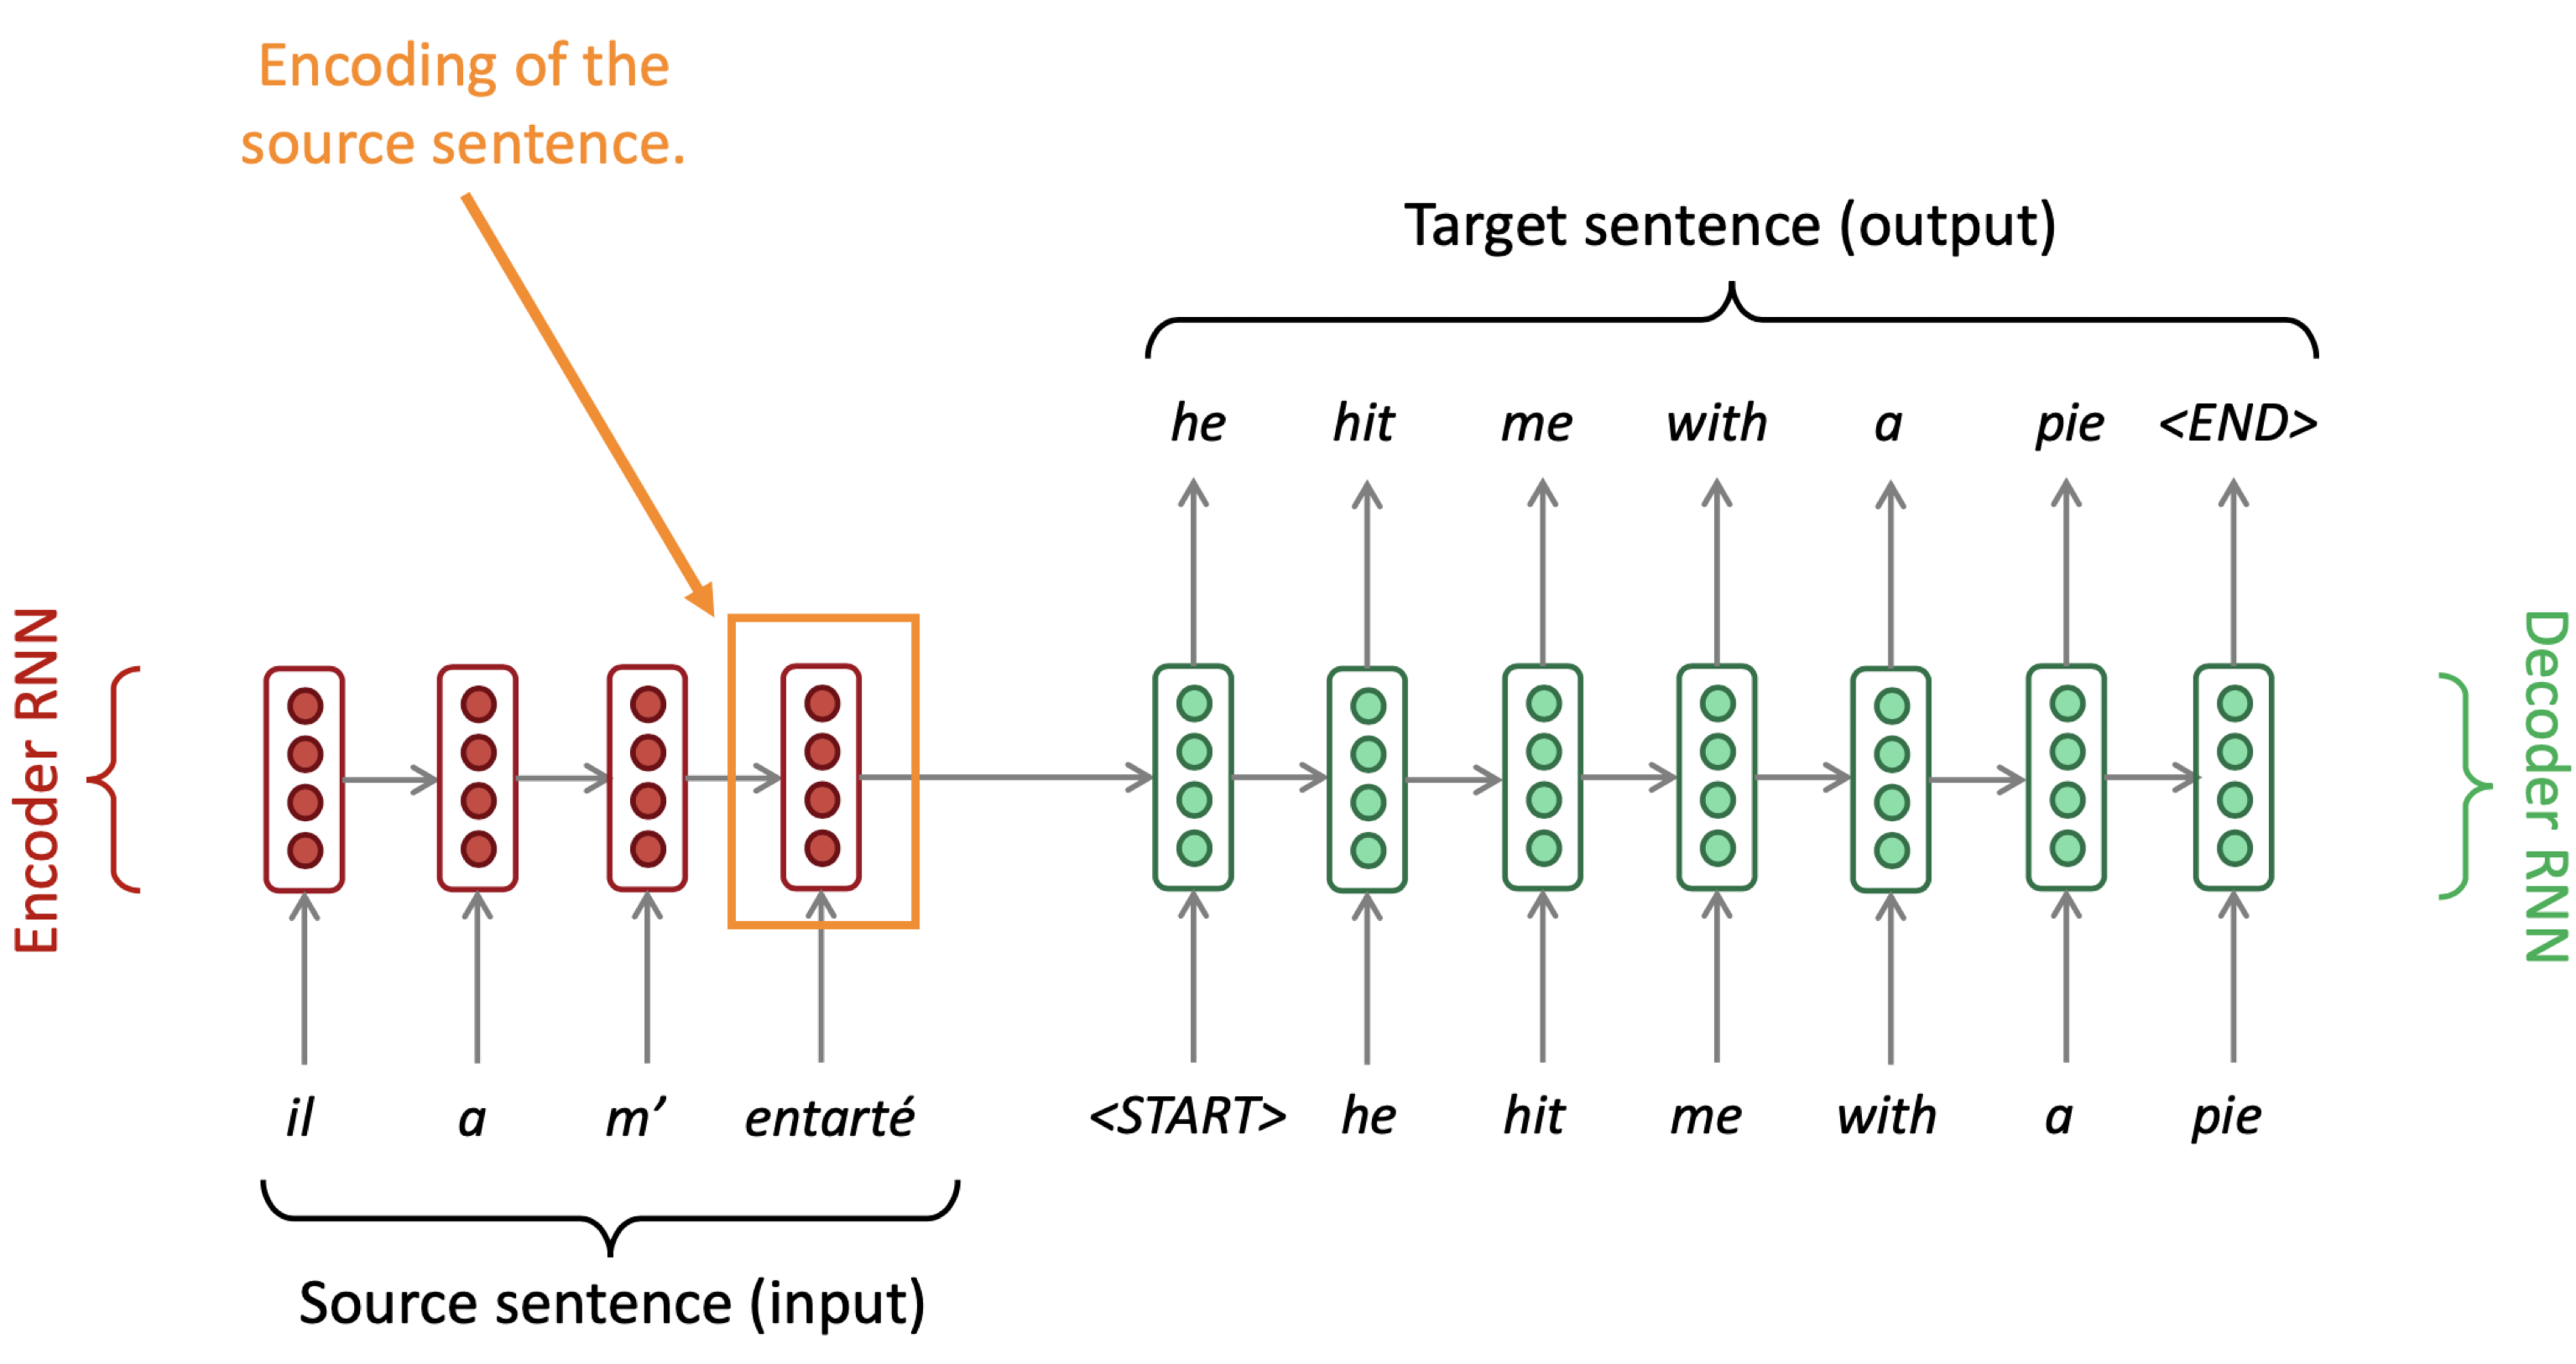

### Encoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### Decoder

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

### Attention Decoder

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

## Training

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:

def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [ ]:

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:

hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

attention_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attention_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

n_epochs = 2
train(train_dataloader, attention_encoder, attention_decoder, n_epochs, print_every=1, plot_every=1)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 10s (- 0m 10s) (1 50%) 2.4863
0m 17s (- 0m 0s) (2 100%) 1.6462


In [ ]:

attention_encoder.eval()
attention_decoder.eval()
evaluateRandomly(attention_encoder, attention_decoder)

> vous allez le regretter
= you re going to regret this
< you re the one who trained me <EOS>

> je suis desole si je t ai effrayee
= i m sorry if i frightened you
< i m sorry if i disturbed you <EOS>

> nous perdons toutes du temps
= we re all wasting time
< we re all the one who trained me <EOS>

> vous etes fort talentueuses
= you re very talented
< you re very timid <EOS>

> je suis en conge cette semaine
= i am on holiday this week
< i m going to go to go <EOS>

> nous cherchons un endroit ou dormir
= we re looking for a place to sleep
< we re going to see a good at home <EOS>

> je me trouve dans une situation desesperee
= i m in a desperate situation
< i m a little <EOS>

> je passe te voir chez toi
= i m coming over to your place
< i m sorry if i disturbed you <EOS>

> il a travaille toute la journee
= he s been working all day long
< he is always at the same age <EOS>

> je n en suis pas persuadee
= i m not persuaded
< i m not sure i m not <EOS>



In [ ]:

hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

n_epochs = 2
train(train_dataloader, encoder, decoder, n_epochs, print_every=1, plot_every=1)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 3s (- 0m 3s) (1 50%) 2.6074
0m 8s (- 0m 0s) (2 100%) 1.7851


In [ ]:

encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> c est un gentleman
= he is quite a gentleman
< he is a good at the same <EOS>

> je ne suis pas interesse par une relation
= i m not interested in a relationship
< i m not sure to have you <EOS>

> tu es au bon endroit
= you re in the right place
< you re the one who trained me <EOS>

> elles sont la pour moi
= they re here for me
< they re all the same <EOS>

> vous etes tres craintives
= you re very timid
< you re not very funny <EOS>

> t es un bon garcon !
= you are a good boy
< you re not allowed to be here <EOS>

> tu es bon menteur
= you re a good liar
< you re the one who trained me <EOS>

> je suis desole de devoir te laisser seul
= i m sorry i had to leave you alone
< i m sorry i didn t you <EOS>

> on le dit decede
= he is said to have died
< we re going to be the same <EOS>

> elle est affairee comme une abeille
= she is as busy as a bee
< she is a good at the same <EOS>



### Visualize attention

In [ ]:
%matplotlib inline

input = il n est pas aussi grand que son pere
output = he is not a good at the same <EOS>


<ipython-input-34-ca773923b167>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-34-ca773923b167>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


<Figure size 640x480 with 0 Axes>

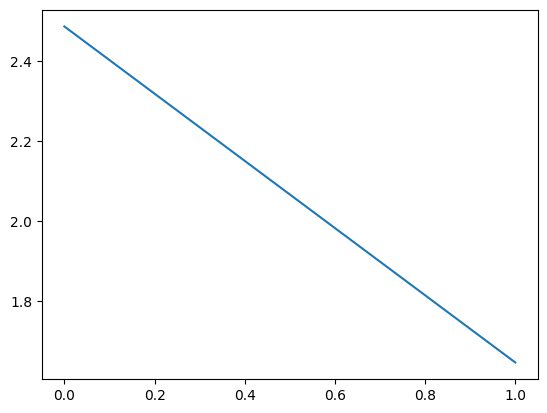

<Figure size 640x480 with 0 Axes>

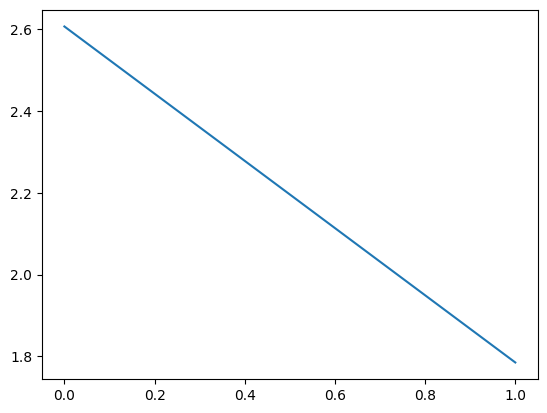

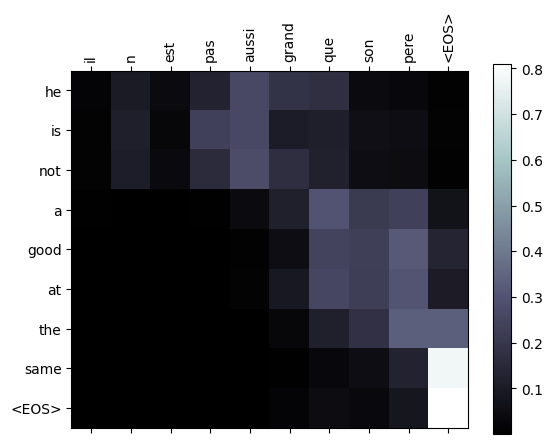

input = je suis trop fatigue pour conduire
output = i m not going to go to go <EOS>


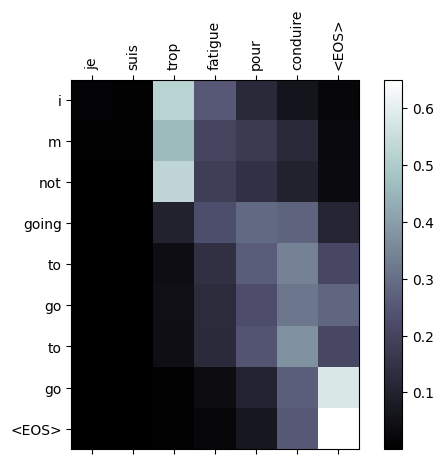

input = je suis desole si c est une question idiote
output = i m sorry i m sorry for a liar <EOS>


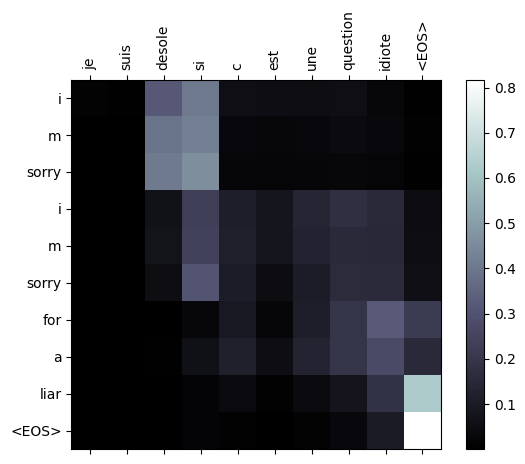

input = je suis reellement fiere de vous
output = i m glad to see you <EOS>


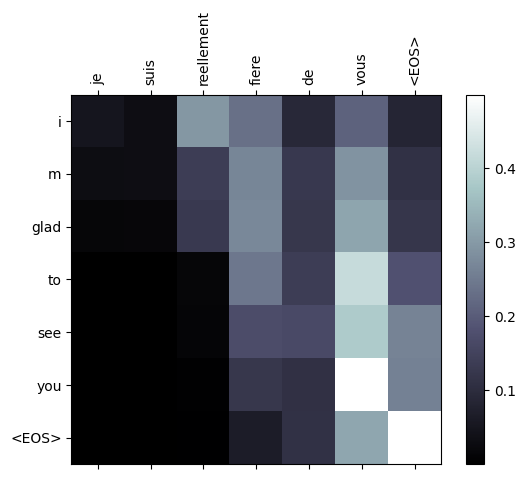

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(attention_encoder, attention_decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

# Transformer

## Self-Attention

In [ ]:
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

import torch
import math

In [ ]:

x = torch.tensor([
  [1.0, 0.0, 1.0, 0.0],
  [0.0, 2.0, 0.0, 2.0],
  [1.0, 1.0, 1.0, 1.0],
])
w_query = torch.tensor([
  [1.0, 0.0, 1.0],
  [1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0],
  [0.0, 1.0, 1.0]
])
w_key = torch.tensor([
  [0.0, 0.0, 1.0],
  [1.0, 1.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 1.0, 0.0]
])
w_value = torch.tensor([
  [0.0, 2.0, 0.0],
  [0.0, 3.0, 0.0],
  [1.0, 0.0, 3.0],
  [1.0, 1.0, 0.0]
])

In [ ]:
keys = torch.matmul(x, w_key)
querys = torch.matmul(x, w_query)
values = torch.matmul(x, w_value)

In [ ]:
attn_scores = torch.matmul(querys, keys.T)
attn_scores

tensor([[ 2.,  4.,  4.],
        [ 4., 16., 12.],
        [ 4., 12., 10.]])

In [ ]:
import numpy as np
from torch.nn.functional import softmax
key_dim_sqrt = np.sqrt(keys.shape[-1])
attn_scores_softmax = softmax(attn_scores / key_dim_sqrt, dim=-1)
attn_scores_softmax

tensor([[1.3613e-01, 4.3194e-01, 4.3194e-01],
        [8.9045e-04, 9.0884e-01, 9.0267e-02],
        [7.4449e-03, 7.5471e-01, 2.3785e-01]])

In [ ]:
weighted_values = torch.matmul(attn_scores_softmax, values)
weighted_values

tensor([[1.8639, 6.3194, 1.7042],
        [1.9991, 7.8141, 0.2735],
        [1.9926, 7.4796, 0.7359]])

## Multi-head Attention

In [ ]:
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

import torch
import math

In [ ]:
pad_id = 0
vocab_size = 100

data = [
  [62, 13, 47, 39, 78, 33, 56, 13, 39, 29, 44, 86, 71, 36, 18, 75],
  [60, 96, 51, 32, 90],
  [35, 45, 48, 65, 91, 99, 92, 10, 3, 21, 54],
  [75, 51],
  [66, 88, 98, 47],
  [21, 39, 10, 64, 21],
  [98],
  [77, 65, 51, 77, 19, 15, 35, 19, 23, 97, 50, 46, 53, 42, 45, 91, 66, 3, 43, 10],
  [70, 64, 98, 25, 99, 53, 4, 13, 69, 62, 66, 76, 15, 75, 45, 34],
  [20, 64, 81, 35, 76, 85, 1, 62, 8, 45, 99, 77, 19, 43]
]

In [ ]:
def padding(data):
  max_len = len(max(data, key=len))
  print(f"Maximum sequence length: {max_len}")

  for i, seq in enumerate(tqdm(data)):
    if len(seq) < max_len:
      data[i] = seq + [pad_id] * (max_len - len(seq))

  return data, max_len

In [ ]:
data, max_len = padding(data)

Maximum sequence length: 20


100%|██████████| 10/10 [00:00<00:00, 88115.63it/s]


In [ ]:
data

[[62, 13, 47, 39, 78, 33, 56, 13, 39, 29, 44, 86, 71, 36, 18, 75, 0, 0, 0, 0],
 [60, 96, 51, 32, 90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [35, 45, 48, 65, 91, 99, 92, 10, 3, 21, 54, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [75, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [66, 88, 98, 47, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [21, 39, 10, 64, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [98, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [77,
  65,
  51,
  77,
  19,
  15,
  35,
  19,
  23,
  97,
  50,
  46,
  53,
  42,
  45,
  91,
  66,
  3,
  43,
  10],
 [70, 64, 98, 25, 99, 53, 4, 13, 69, 62, 66, 76, 15, 75, 45, 34, 0, 0, 0, 0],
 [20, 64, 81, 35, 76, 85, 1, 62, 8, 45, 99, 77, 19, 43, 0, 0, 0, 0, 0, 0]]

In [ ]:
d_model = 512  # model의 hidden size
num_heads = 8  # head의 개수

In [ ]:
embedding = nn.Embedding(vocab_size, d_model)

# B: batch size, L: maximum sequence length
batch = torch.LongTensor(data)  # (B, L)
batch_emb = embedding(batch)  # (B, L, d_model)

In [ ]:
print(batch_emb)
print(batch_emb.shape)

tensor([[[ 1.0318, -1.2243,  1.1932,  ..., -0.6027,  0.9165, -0.8688],
         [ 0.5870, -2.1089,  0.6547,  ...,  2.0266,  1.1725,  1.2081],
         [ 0.8738,  1.0207,  0.3177,  ..., -1.4418, -1.0993, -0.9487],
         ...,
         [ 1.7082, -1.7661,  0.7683,  ..., -1.6156,  1.7132, -1.0061],
         [ 1.7082, -1.7661,  0.7683,  ..., -1.6156,  1.7132, -1.0061],
         [ 1.7082, -1.7661,  0.7683,  ..., -1.6156,  1.7132, -1.0061]],

        [[-0.8840, -0.1562, -0.7226,  ..., -0.6635, -0.8948,  1.0691],
         [ 0.1846, -0.7294, -0.1580,  ..., -0.9398,  2.1583, -0.4127],
         [ 0.3867, -1.0346,  0.3871,  ...,  1.5007, -0.7766, -0.0375],
         ...,
         [ 1.7082, -1.7661,  0.7683,  ..., -1.6156,  1.7132, -1.0061],
         [ 1.7082, -1.7661,  0.7683,  ..., -1.6156,  1.7132, -1.0061],
         [ 1.7082, -1.7661,  0.7683,  ..., -1.6156,  1.7132, -1.0061]],

        [[-0.1074, -0.0228,  1.9120,  ...,  1.0201,  0.2085, -0.4112],
         [ 0.0742, -1.2926, -0.1843,  ...,  1

In [ ]:
w_q = nn.Linear(d_model, d_model)
w_k = nn.Linear(d_model, d_model)
w_v = nn.Linear(d_model, d_model)

In [ ]:
w_0 = nn.Linear(d_model, d_model)

In [ ]:
q = w_q(batch_emb)  # (B, L, d_model)
k = w_k(batch_emb)  # (B, L, d_model)
v = w_v(batch_emb)  # (B, L, d_model)

print(q.shape)
print(k.shape)
print(v.shape)

torch.Size([10, 20, 512])
torch.Size([10, 20, 512])
torch.Size([10, 20, 512])


In [ ]:
batch_size = q.shape[0]
d_k = d_model // num_heads

q = q.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
k = k.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
v = v.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)

print(q.shape)
print(k.shape)
print(v.shape)

torch.Size([10, 20, 8, 64])
torch.Size([10, 20, 8, 64])
torch.Size([10, 20, 8, 64])


In [ ]:
q = q.transpose(1, 2)  # (B, num_heads, L, d_k)
k = k.transpose(1, 2)  # (B, num_heads, L, d_k)
v = v.transpose(1, 2)  # (B, num_heads, L, d_k)

print(q.shape)
print(k.shape)
print(v.shape)

torch.Size([10, 8, 20, 64])
torch.Size([10, 8, 20, 64])
torch.Size([10, 8, 20, 64])


In [ ]:
attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # (B, num_heads, L, L)
attn_dists = F.softmax(attn_scores, dim=-1)  # (B, num_heads, L, L)

print(attn_dists)
print(attn_dists.shape)

tensor([[[[0.0480, 0.0315, 0.0478,  ..., 0.0369, 0.0369, 0.0369],
          [0.0527, 0.0368, 0.0449,  ..., 0.0623, 0.0623, 0.0623],
          [0.0261, 0.0281, 0.0318,  ..., 0.0759, 0.0759, 0.0759],
          ...,
          [0.0670, 0.0323, 0.0599,  ..., 0.0382, 0.0382, 0.0382],
          [0.0670, 0.0323, 0.0599,  ..., 0.0382, 0.0382, 0.0382],
          [0.0670, 0.0323, 0.0599,  ..., 0.0382, 0.0382, 0.0382]],

         [[0.0486, 0.0463, 0.0422,  ..., 0.0536, 0.0536, 0.0536],
          [0.0420, 0.0350, 0.0647,  ..., 0.0600, 0.0600, 0.0600],
          [0.0635, 0.0313, 0.0611,  ..., 0.0595, 0.0595, 0.0595],
          ...,
          [0.0707, 0.0489, 0.0395,  ..., 0.0720, 0.0720, 0.0720],
          [0.0707, 0.0489, 0.0395,  ..., 0.0720, 0.0720, 0.0720],
          [0.0707, 0.0489, 0.0395,  ..., 0.0720, 0.0720, 0.0720]],

         [[0.0427, 0.0497, 0.0498,  ..., 0.0432, 0.0432, 0.0432],
          [0.0470, 0.0563, 0.0347,  ..., 0.0446, 0.0446, 0.0446],
          [0.0609, 0.0438, 0.0670,  ..., 0

In [ ]:
attn_values = torch.matmul(attn_dists, v)  # (B, num_heads, L, d_k)

print(attn_values.shape)

torch.Size([10, 8, 20, 64])


In [ ]:
attn_values = attn_values.transpose(1, 2)  # (B, L, num_heads, d_k)
attn_values = attn_values.contiguous().view(batch_size, -1, d_model)  # (B, L, d_model)

print(attn_values.shape)

torch.Size([10, 20, 512])


In [ ]:
outputs = w_0(attn_values)

print(outputs)
print(outputs.shape)

tensor([[[-0.0509, -0.0547,  0.1188,  ...,  0.0061, -0.0669, -0.0453],
         [-0.1180, -0.0069,  0.1110,  ...,  0.0044, -0.0649, -0.0622],
         [-0.1147, -0.0007,  0.1267,  ..., -0.0437, -0.0445, -0.0306],
         ...,
         [-0.0543, -0.0294,  0.1527,  ..., -0.0731, -0.0903,  0.0143],
         [-0.0543, -0.0294,  0.1527,  ..., -0.0731, -0.0903,  0.0143],
         [-0.0543, -0.0294,  0.1527,  ..., -0.0731, -0.0903,  0.0143]],

        [[-0.3213,  0.0955,  0.1134,  ...,  0.0658,  0.2308, -0.0449],
         [-0.3884,  0.1235,  0.1090,  ...,  0.0430,  0.2692, -0.0355],
         [-0.3306,  0.0884,  0.1309,  ...,  0.0541,  0.2474, -0.0592],
         ...,
         [-0.3542,  0.1149,  0.1345,  ...,  0.0890,  0.2803, -0.0130],
         [-0.3542,  0.1149,  0.1345,  ...,  0.0890,  0.2803, -0.0130],
         [-0.3542,  0.1149,  0.1345,  ...,  0.0890,  0.2803, -0.0130]],

        [[-0.1619,  0.0892,  0.1040,  ...,  0.1310,  0.1810, -0.0398],
         [-0.0985,  0.1159,  0.1018,  ...,  0

In [ ]:
class MultiheadAttention(nn.Module):
  def __init__(self):
    super(MultiheadAttention, self).__init__()

    # Q, K, V learnable matrices
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)

    # Linear transformation for concatenated outputs
    self.w_0 = nn.Linear(d_model, d_model)

  def forward(self, q, k, v):
    batch_size = q.shape[0]

    q = self.w_q(q)  # (B, L, d_model)
    k = self.w_k(k)  # (B, L, d_model)
    v = self.w_v(v)  # (B, L, d_model)

    q = q.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
    k = k.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
    v = v.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)

    q = q.transpose(1, 2)  # (B, num_heads, L, d_k)
    k = k.transpose(1, 2)  # (B, num_heads, L, d_k)
    v = v.transpose(1, 2)  # (B, num_heads, L, d_k)

    attn_values = self.self_attention(q, k, v)  # (B, num_heads, L, d_k)
    attn_values = attn_values.transpose(1, 2).contiguous().view(batch_size, -1, d_model)  # (B, L, num_heads, d_k) => (B, L, d_model)

    return self.w_0(attn_values)

  def self_attention(self, q, k, v):
    attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # (B, num_heads, L, L)
    attn_dists = F.softmax(attn_scores, dim=-1)  # (B, num_heads, L, L)

    attn_values = torch.matmul(attn_dists, v)  # (B, num_heads, L, d_k)

    return attn_values

In [ ]:
multihead_attn = MultiheadAttention()

outputs = multihead_attn(batch_emb, batch_emb, batch_emb)  # (B, L, d_model)

In [ ]:
print(outputs)
print(outputs.shape)

tensor([[[-0.0303, -0.3016,  0.0999,  ...,  0.1006, -0.1069,  0.0387],
         [ 0.0627, -0.3222,  0.1300,  ...,  0.0748, -0.0425,  0.0379],
         [-0.0415, -0.3172,  0.0373,  ...,  0.1024, -0.0630,  0.1153],
         ...,
         [ 0.0314, -0.3142,  0.1025,  ...,  0.1038, -0.0436,  0.1391],
         [ 0.0314, -0.3142,  0.1025,  ...,  0.1038, -0.0436,  0.1391],
         [ 0.0314, -0.3142,  0.1025,  ...,  0.1038, -0.0436,  0.1391]],

        [[-0.0261, -0.2350,  0.5352,  ..., -0.0052, -0.1421, -0.2897],
         [-0.0177, -0.2782,  0.5491,  ...,  0.0049, -0.0977, -0.2940],
         [ 0.0326, -0.2730,  0.5956,  ...,  0.0357, -0.0380, -0.2986],
         ...,
         [-0.0346, -0.3006,  0.5647,  ...,  0.0155, -0.0897, -0.3009],
         [-0.0346, -0.3006,  0.5647,  ...,  0.0155, -0.0897, -0.3009],
         [-0.0346, -0.3006,  0.5647,  ...,  0.0155, -0.0897, -0.3009]],

        [[ 0.0921, -0.1009,  0.2914,  ..., -0.0397,  0.0123, -0.1585],
         [ 0.0943, -0.1407,  0.1899,  ..., -0

## Masked Multi-head Attention

In [ ]:
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

import torch
import math

In [ ]:
pad_id = 0
vocab_size = 100


# 단어를 토크나이저를 사용해 단어 인덱스로 변환한 상태
data = [
  [62, 13, 47, 39, 78, 33, 56, 13],
  [60, 96, 51, 32, 90],
  [35, 45, 48, 65, 91, 99, 92, 10, 3, 21],
  [66, 88, 98, 47],
  [77, 65, 51, 77, 19, 15, 35, 19, 23]
]

In [ ]:
def padding(data):
    # 배치안의 문장의 길이는 각각 다르기 때문에 모델의 입력으로 사용하기 위해서는 입력길이를 모두 똑같이 만들어 줘야함
    max_len = len(max(data, key=len))
    print(f"Maximum sequence length: {max_len}")

    for i, seq in enumerate(tqdm(data)):
        if len(seq) < max_len:
            data[i] = seq + [pad_id] * (max_len - len(seq))

    return data, max_len

In [ ]:
data, max_len = padding(data)

Maximum sequence length: 10


100%|██████████| 5/5 [00:00<00:00, 41527.76it/s]


In [ ]:
d_model = 8  # model의 hidden size
num_heads = 2  # head의 개수
inf = 1e12

In [ ]:
embedding = nn.Embedding(vocab_size, d_model)

# B: batch size, L: maximum sequence length
batch = torch.LongTensor(data)  # (B, L)
batch_emb = embedding(batch)  # (B, L, d_model)

In [ ]:
print(batch_emb)
print(batch_emb.shape)

tensor([[[ 1.0488,  1.0841,  0.3875, -0.3181,  0.5945,  0.1802,  0.3992,
           1.1598],
         [ 0.5181,  0.5706,  0.1004,  0.9786,  0.0849, -0.9325,  0.3080,
           0.8536],
         [ 0.1284,  0.0840, -1.1562, -1.2851, -0.5005,  0.6413,  1.2958,
          -1.6995],
         [ 0.3935, -1.2565,  1.4573, -0.6011, -0.1324,  0.4667, -0.6471,
           0.2869],
         [ 0.8750,  0.4904, -0.1661, -0.9566,  0.8205,  1.1191,  0.4282,
          -0.1959],
         [-1.2921,  0.8744, -0.1708,  0.9754,  0.4060, -1.7901,  0.5054,
           1.1783],
         [-1.4364,  1.3493, -0.8541,  0.4082,  0.5544,  0.3675, -2.0443,
          -0.0950],
         [ 0.5181,  0.5706,  0.1004,  0.9786,  0.0849, -0.9325,  0.3080,
           0.8536],
         [ 1.2907,  0.1506, -0.8916,  3.4806,  0.7016, -0.0677,  1.2650,
          -0.0395],
         [ 1.2907,  0.1506, -0.8916,  3.4806,  0.7016, -0.0677,  1.2650,
          -0.0395]],

        [[ 0.2780, -0.5309,  0.0571, -1.6959,  0.7256,  1.8471,  0.4

In [ ]:
padding_mask = (batch != pad_id).unsqueeze(1)  # (B, 1, L)

print(padding_mask)
print(padding_mask.shape)

tensor([[[ True,  True,  True,  True,  True,  True,  True,  True, False, False]],

        [[ True,  True,  True,  True,  True, False, False, False, False, False]],

        [[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]],

        [[ True,  True,  True,  True, False, False, False, False, False, False]],

        [[ True,  True,  True,  True,  True,  True,  True,  True,  True, False]]])
torch.Size([5, 1, 10])


In [ ]:
nopeak_mask = torch.ones([1, max_len, max_len], dtype=torch.bool)  # (1, L, L)
nopeak_mask = torch.tril(nopeak_mask)  # (1, L, L)

print(nopeak_mask)
print(nopeak_mask.shape)

tensor([[[ True, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]])
torch.Size([1, 10, 10])


In [ ]:
mask = padding_mask & nopeak_mask  # (B, L, L)

print(mask)
print(mask.shape)

tensor([[[ True, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False]],

        [[ True, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False],
         [ True,  True,  T

In [ ]:
w_q = nn.Linear(d_model, d_model)
w_k = nn.Linear(d_model, d_model)
w_v = nn.Linear(d_model, d_model)

w_0 = nn.Linear(d_model, d_model)

In [ ]:
q = w_q(batch_emb)  # (B, L, d_model)
k = w_k(batch_emb)  # (B, L, d_model)
v = w_v(batch_emb)  # (B, L, d_model)

batch_size = q.shape[0]
d_k = d_model // num_heads

q = q.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
k = k.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
v = v.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)

q = q.transpose(1, 2)  # (B, num_heads, L, d_k)
k = k.transpose(1, 2)  # (B, num_heads, L, d_k)
v = v.transpose(1, 2)  # (B, num_heads, L, d_k)

print(q.shape)
print(k.shape)
print(v.shape)

torch.Size([5, 2, 10, 4])
torch.Size([5, 2, 10, 4])
torch.Size([5, 2, 10, 4])


In [ ]:
attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # (B, num_heads, L, L)

In [ ]:
masks = mask.unsqueeze(1)  # (B, 1, L, L)
masked_attn_scores = attn_scores.masked_fill_(masks == False, -1 * inf)  # (B, num_heads, L, L)

print(masked_attn_scores)
print(masked_attn_scores.shape)

tensor([[[[ 3.1263e-02, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12,
           -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
          [ 3.6784e-02, -2.0116e-01, -1.0000e+12, -1.0000e+12, -1.0000e+12,
           -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
          [ 4.4034e-02,  1.0388e-01, -1.9694e-01, -1.0000e+12, -1.0000e+12,
           -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
          [-1.9601e-02, -1.4444e-01,  2.7351e-01, -1.0321e-01, -1.0000e+12,
           -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
          [-3.4517e-03, -1.2586e-04, -1.7900e-01,  3.2561e-01,  7.9368e-02,
           -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
          [ 7.2758e-02, -1.6019e-01,  5.0695e-01, -2.6086e-01,  1.8198e-01,
           -9.1211e-02, -1.0000e+12, -1.0000e+12, -1.0000e+12, -1.0000e+12],
          [-2.0286e-01, -3.8985e-02, -1.1888e-01, -3.0597e-01, -2.0788e-01,
      

In [ ]:
attn_dists = F.softmax(masked_attn_scores, dim=-1)  # (B, num_heads, L, L)

print(attn_dists)
print(attn_dists.shape)

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.5592, 0.4408, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.3512, 0.3728, 0.2760, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.2414, 0.2130, 0.3236, 0.2220, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.1880, 0.1887, 0.1578, 0.2613, 0.2043, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.1662, 0.1317, 0.2566, 0.1191, 0.1854, 0.1411, 0.0000, 0.0000,
           0.0000, 0.0000],
          [0.1208, 0.1423, 0.1314, 0.1089, 0.1202, 0.2024, 0.1740, 0.0000,
           0.0000, 0.0000],
          [0.1304, 0.1028, 0.1712, 0.1061, 0.1565, 0.0990, 0.1311, 0.1028,
           0.0000, 0.0000],
          [0.1216, 0.1052, 0.1447, 0.0978, 0.1492, 0.1183, 0.1581, 0.1052,
           0.0000, 0.0000],
          [0.1216, 0.1052, 0.1447, 0.0978, 0.1492, 0.1183, 0.1581, 0.1052

In [ ]:
attn_values = torch.matmul(attn_dists, v)  # (B, num_heads, L, d_k)

print(attn_values.shape)

torch.Size([5, 2, 10, 4])


In [ ]:
class MultiheadAttention(nn.Module):
  def __init__(self):
    super(MultiheadAttention, self).__init__()

    # Q, K, V learnable matrices
    self.w_q = nn.Linear(d_model, d_model)
    self.w_k = nn.Linear(d_model, d_model)
    self.w_v = nn.Linear(d_model, d_model)

    # Linear transformation for concatenated outputs
    self.w_0 = nn.Linear(d_model, d_model)

  def forward(self, q, k, v, mask=None):
    batch_size = q.shape[0]

    q = self.w_q(q)  # (B, L, d_model)
    k = self.w_k(k)  # (B, L, d_model)
    v = self.w_v(v)  # (B, L, d_model)

    q = q.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
    k = k.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)
    v = v.view(batch_size, -1, num_heads, d_k)  # (B, L, num_heads, d_k)

    q = q.transpose(1, 2)  # (B, num_heads, L, d_k)
    k = k.transpose(1, 2)  # (B, num_heads, L, d_k)
    v = v.transpose(1, 2)  # (B, num_heads, L, d_k)

    attn_values = self.self_attention(q, k, v, mask=mask)  # (B, num_heads, L, d_k)
    attn_values = attn_values.transpose(1, 2).contiguous().view(batch_size, -1, d_model)  # (B, L, num_heads, d_k) => (B, L, d_model)

    return self.w_0(attn_values)

  def self_attention(self, q, k, v, mask=None):
    attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # (B, num_heads, L, L)

    if mask is not None:
      mask = mask.unsqueeze(1)  # (B, 1, L, L) or  (B, 1, 1, L)
      attn_scores = attn_scores.masked_fill_(mask == False, -1*inf)

    attn_dists = F.softmax(attn_scores, dim=-1)  # (B, num_heads, L, L)

    attn_values = torch.matmul(attn_dists, v)  # (B, num_heads, L, d_k)

    return attn_values

In [ ]:
multihead_attn = MultiheadAttention()

outputs = multihead_attn(batch_emb, batch_emb, batch_emb, mask=mask)  # (B, L, d_model)

In [ ]:
print(outputs)
print(outputs.shape)

tensor([[[-0.0422,  0.4169,  0.0195, -0.5387, -0.0622,  0.4874, -0.1104,
          -0.4329],
         [-0.0805,  0.3339, -0.1417, -0.5036,  0.0036,  0.4891, -0.2491,
          -0.3399],
         [ 0.1944,  0.2622,  0.0451, -0.3312,  0.1029,  0.4759, -0.0344,
          -0.2415],
         [ 0.1796,  0.1627,  0.0699, -0.2577,  0.0405,  0.3725, -0.0052,
          -0.1865],
         [ 0.2006,  0.2174,  0.1086, -0.2826,  0.0154,  0.3927,  0.0476,
          -0.2000],
         [ 0.0080,  0.2624, -0.1386, -0.4032, -0.0054,  0.4468, -0.1321,
          -0.1009],
         [-0.0709,  0.3714, -0.2646, -0.4225, -0.2072,  0.3767, -0.0792,
           0.2127],
         [-0.0647,  0.3336, -0.2313, -0.4654, -0.0762,  0.5063, -0.1056,
           0.0558],
         [-0.1184,  0.3949, -0.2651, -0.5219, -0.1470,  0.5740, -0.0193,
           0.1849],
         [-0.1184,  0.3949, -0.2651, -0.5219, -0.1470,  0.5740, -0.0193,
           0.1849]],

        [[-0.1023,  0.4350,  0.3800, -0.5352, -0.5706,  0.2505,  0.4

## Full Architecture

### 필요 패키지 import, 헬퍼함수 정의

In [ ]:
!pip install -q GPUtil


In [ ]:

import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
# import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [ ]:
# 전체 노트북에 걸쳐 사용되는 몇 가지 편리한 헬퍼 함수

def is_interactive_notebook():
    # 이 함수는 현재 코드가 주피터 노트북 등의 대화형 환경에서 실행되는지 확인합니다.
    return __name__ == "__main__"

def show_example(fn, args=[]):
    # 이 함수는 주어진 함수 'fn'을 실행하고 그 결과를 반환합니다.
    # 이 코드는 대화형 노트북에서 예제를 실행할 때만 동작합니다.
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

def execute_example(fn, args=[]):
    # 이 함수는 주어진 함수 'fn'을 실행합니다.
    # 이 코드는 대화형 노트북에서 예제를 실행할 때만 동작합니다.
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)

class DummyOptimizer(torch.optim.Optimizer):
    # 이 클래스는 파이토치의 최적화 기능을 모방하는 더미 클래스입니다.
    # 'step'과 'zero_grad' 메서드는 아무런 동작도 수행하지 않습니다.
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        # 최적화 단계를 진행하는 메서드. 여기서는 아무런 동작도 수행하지 않습니다.
        None

    def zero_grad(self, set_to_none=False):
        # 그래디언트를 0으로 초기화하는 메서드. 여기서는 아무런 동작도 수행하지 않습니다.
        None


class DummyScheduler:
    # 이 클래스는 학습률 스케줄러의 기능을 모방하는 더미 클래스입니다.
    def step(self):
        # 학습률을 조정하는 단계를 진행하는 메서드. 여기서는 아무런 동작도 수행하지 않습니다.
        None


![](https://github.com/harvardnlp/annotated-transformer/blob/master/images/ModalNet-21.png?raw=1)

In [ ]:
class EncoderDecoder(nn.Module):
    """
    표준 인코더-디코더 아키텍처. 이 모델과 다른 많은 모델들의 기반이 됩니다.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder  # 인코더 부분
        self.decoder = decoder  # 디코더 부분
        self.src_embed = src_embed  # 소스 언어의 임베딩
        self.tgt_embed = tgt_embed  # 타겟 언어의 임베딩
        self.generator = generator  # 출력을 생성하는 부분

    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        마스크가 적용된 소스와 타겟 시퀀스를 입력 받아 처리합니다.
        """
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        # 소스 시퀀스를 인코딩하는 부분입니다.
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        # 인코딩된 메모리를 기반으로 디코딩하는 부분입니다.
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)


In [ ]:
class Generator(nn.Module):
    """표준 선형 + 소프트맥스 생성 단계를 정의합니다.
    이 Generator 클래스는 모델의 마지막 단계에서 사용되며, 각 단어의 확률 분포를 출력.
    이는 디코더에서 출력된 특징 벡터를 받아서 선형 변환 후, log_softmax를 적용하여 각 단어의 로그 확률을 계산
    """

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)  # 선형 변환을 위한 레이어를 정의합니다.

    def forward(self, x):
        # 입력 x에 대해 선형 변환을 수행한 뒤, log_softmax를 적용하여 출력을 생성합니다.
        return log_softmax(self.proj(x), dim=-1)


### Encoder and Decoder Stacks



#### Encoder

encoder는 L개의 레이어 개수를 가진다.

In [ ]:
def clones(module, N):
    "N개의 동일한 레이어를 생성합니다."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


In [ ]:
class Encoder(nn.Module):
    "인코더는 N개의 레이어 스택"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)  # N개의 동일한 레이어를 생성합니다.
        self.norm = LayerNorm(layer.size)  # 마지막에 적용할 레이어 정규화입니다.

    def forward(self, x, mask):
        "입력 (그리고 마스크)를 각 레이어에 순차적으로 통과"
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)  # 모든 레이어를 거친 후, 레이어 정규화를 적용합니다.


Attention Layer, Position-Wise Feed Forward Layer 이후에 Layer Norm, Residual Connection이 적용됨


$\mathrm{LayerNorm}(x +
\mathrm{Sublayer}(x))$

In [ ]:
class LayerNorm(nn.Module):
    "레이어 정규화 모듈을 구성"

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))  # 스케일 파라미터, 학습 가능
        self.b_2 = nn.Parameter(torch.zeros(features))  # 이동 파라미터, 학습 가능
        self.eps = eps  # 0으로 나누는 것을 방지하기 위한 작은 값

    def forward(self, x):
        # 입력 x의 평균(mean)과 표준편차(std)를 계산합니다.
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        # 평균을 빼고 표준편차로 나눈 후 스케일링하고 이동시킵니다.
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


In [ ]:
class SublayerConnection(nn.Module):
    """
    레이어 정규화 다음에 이어지는 잔차 연결입니다.
    코드의 간결함을 위해, 정규화가 먼저 적용되며 이는 일반적인 순서와는 반대입니다.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)  # 레이어 정규화를 위한 인스턴스
        self.dropout = nn.Dropout(dropout)  # 드롭아웃을 위한 인스턴스

    def forward(self, x, sublayer):
        "같은 크기를 가진 모든 서브레이어에 잔차 연결을 적용합니다."
        return x + self.dropout(sublayer(self.norm(x)))  # 잔차 연결과 드롭아웃 적용


In [ ]:
class EncoderLayer(nn.Module):
    "인코더는 self-attention과 feed forward로 구성"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn  # 자기 주목 메커니즘
        self.feed_forward = feed_forward  # 피드포워드 네트워크
        self.sublayer = clones(SublayerConnection(size, dropout), 2)  # 잔차 연결과 레이어 정규화
        self.size = size

    def forward(self, x, mask):
        "Figure 1 (왼쪽) 부분"
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))  # 자기 주목 적용
        return self.sublayer[1](x, self.feed_forward)  # 피드포워드 네트워크 적용


#### Decoder

decoder는 L개의 레이어 개수를 가진다.

In [ ]:
class Decoder(nn.Module):
    "마스킹이 포함된 일반적인 N개 레이어 디코더."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)  # N개의 동일한 레이어를 생성합니다.
        self.norm = LayerNorm(layer.size)  # 마지막에 적용할 레이어 정규화입니다.

    def forward(self, x, memory, src_mask, tgt_mask):
        # 각 레이어를 통과하며, 각 레이어에는 입력, 메모리, 소스 마스크, 타겟 마스크가 전달됩니다.
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)  # 모든 레이어를 거친 후, 레이어 정규화를 적용합니다.


In [ ]:
class DecoderLayer(nn.Module):
    "디코더는 자기 주목(self-attn), 소스 주목(src-attn), 그리고 피드포워드(feed forward)로 구성됩니다."

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn  # 자기 주목 메커니즘
        self.src_attn = src_attn  # 소스 주목 메커니즘
        self.feed_forward = feed_forward  # 피드포워드 네트워크
        self.sublayer = clones(SublayerConnection(size, dropout), 3)  # 잔차 연결과 레이어 정규화

    def forward(self, x, memory, src_mask, tgt_mask):
        "Figure 1 (오른쪽)의 연결을 따릅니다."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))  # 자기 주목 적용
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))  # 소스 주목 적용
        return self.sublayer[2](x, self.feed_forward)  # 피드포워드 네트워크 적용


In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

In [ ]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

alt.Chart(...)

#### Attention




$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Scaled Dot Product Attention 계산"
    d_k = query.size(-1)  # query의 마지막 차원의 크기
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)  # 점곱 후 스케일링
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)  # 마스크가 적용된 부분을 극소값으로 설정
    p_attn = scores.softmax(dim=-1)  # 소프트맥스를 적용하여 확률 분포로 변환
    if dropout is not None:
        p_attn = dropout(p_attn)  # 드롭아웃 적용
    return torch.matmul(p_attn, value), p_attn  # 가중치와 value 벡터를 곱하고 결과를 반환


![](https://github.com/harvardnlp/annotated-transformer/blob/master/images/ModalNet-20.png?raw=1)

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "모델의 크기와 헤드의 수를 입력으로 받습니다."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0  # d_model이 h로 나누어 떨어져야 합니다.
        # d_v는 항상 d_k와 같다고 가정합니다.
        self.d_k = d_model // h  # 각 헤드의 차원 크기
        self.h = h  # 헤드의 수
        self.linears = clones(nn.Linear(d_model, d_model), 4)  # 선형 변환을 위한 레이어들
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Figure 2를 구현합니다."
        if mask is not None:
            # 모든 h 헤드에 동일한 마스크를 적용합니다.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) 배치에서 d_model => h x d_k로 모든 선형 투영을 수행합니다.
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) 배치에 있는 모든 투영된 벡터에 어텐션을 적용합니다.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat"을 view를 사용하여 수행하고, 마지막 선형 변환을 적용합니다.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        return self.linears[-1](x)


![](https://github.com/harvardnlp/annotated-transformer/blob/master/images/ModalNet-21.png?raw=1)

### Position-wise Feed-Forward Networks



$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$


In [ ]:
class PositionwiseFeedForward(nn.Module):
    "FFN(Feed-Forward Network) 구현"

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)  # 첫번째 선형 변환
        self.w_2 = nn.Linear(d_ff, d_model)  # 두번째 선형 변환
        self.dropout = nn.Dropout(dropout)  # 드롭아웃

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))  # 활성화 함수(ReLU)와 드롭아웃 적용 후, 두번째 선형 변환 수행


### Embeddings and Softmax

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)  # 임베딩 레이어
        self.d_model = d_model  # 임베딩 차원

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)  # 임베딩과 스케일링


### Positional Encoding



$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$


In [ ]:
class PositionalEncoding(nn.Module):
    "PE(Positional Encoding) 함수를 구현합니다."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)  # 드롭아웃 레이어

        # 로그 공간에서 한 번에 위치 인코딩을 계산합니다.
        pe = torch.zeros(max_len, d_model)  # 위치 인코딩 행렬 초기화
        position = torch.arange(0, max_len).unsqueeze(1)  # 각 위치 값
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )  # 스케일링 팩터
        pe[:, 0::2] = torch.sin(position * div_term)  # 짝수 인덱스
        pe[:, 1::2] = torch.cos(position * div_term)  # 홀수 인덱스
        pe = pe.unsqueeze(0)  # 차원 추가
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)  # 입력에 위치 인코딩 추가
        return self.dropout(x)  # 드롭아웃 적용 후 반환


In [ ]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

alt.Chart(...)

### Full Model

In [ ]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "하이퍼파라미터로부터 모델을 생성하는 도우미 함수입니다."
    c = copy.deepcopy  # 객체 복사를 위한 도우미 함수
    attn = MultiHeadedAttention(h, d_model)  # 멀티헤드 어텐션
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)  # 피드포워드 네트워크
    position = PositionalEncoding(d_model, dropout)  # 위치 인코딩
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),  # 인코더
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),  # 디코더
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),  # 소스 임베딩
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),  # 타겟 임베딩
        Generator(d_model, tgt_vocab),  # 출력 생성기
    )


    # xavier_uniform_를 사용하여 파라미터를 초기화합니다.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model


### Inference

In [ ]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    # Greedy Deocding
    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[ 0,  9,  5, 10, 10,  3, 10,  3, 10,  6]])
Example Untrained Model Prediction: tensor([[ 0, 10, 10, 10, 10, 10, 10, 10, 10, 10]])
Example Untrained Model Prediction: tensor([[0, 3, 3, 3, 3, 3, 3, 3, 3, 3]])
Example Untrained Model Prediction: tensor([[ 0,  1,  4, 10,  9,  1,  4, 10,  1,  4]])
Example Untrained Model Prediction: tensor([[0, 9, 0, 7, 0, 3, 0, 7, 0, 7]])
Example Untrained Model Prediction: tensor([[0, 3, 7, 1, 7, 1, 7, 1, 7, 1]])
Example Untrained Model Prediction: tensor([[0, 6, 5, 4, 7, 7, 7, 7, 7, 7]])
Example Untrained Model Prediction: tensor([[0, 6, 8, 7, 7, 7, 7, 7, 7, 7]])
Example Untrained Model Prediction: tensor([[0, 6, 4, 4, 4, 4, 4, 4, 4, 4]])
Example Untrained Model Prediction: tensor([[0, 6, 2, 6, 3, 6, 3, 6, 2, 5]])


# Efficient Attention

In [ ]:
import math
import torch
from torch import nn
import torch.nn.functional as F

from linformer.reversible import ReversibleSequence, SequentialSequence

# helper functions

def default(val, default_val):
    return val if val is not None else default_val

def init_(tensor):
    dim = tensor.shape[-1]
    std = 1 / math.sqrt(dim)
    tensor.uniform_(-std, std)
    return tensor

# helper classes

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return x + self.fn(x)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class GELU_(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

GELU = nn.GELU if hasattr(nn, 'GELU') else GELU_

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0., activation = None, glu = False):
        super().__init__()
        activation = default(activation, GELU)

        self.glu = glu
        self.w1 = nn.Linear(dim, dim * mult * (2 if glu else 1))
        self.act = activation()
        self.dropout = nn.Dropout(dropout)
        self.w2 = nn.Linear(dim * mult, dim)

    def forward(self, x, **kwargs):
        if not self.glu:
            x = self.w1(x)
            x = self.act(x)
        else:
            x, v = self.w1(x).chunk(2, dim=-1)
            x = self.act(x) * v

        x = self.dropout(x)
        x = self.w2(x)
        return x

class LinformerSelfAttention(nn.Module):
    def __init__(self, dim, seq_len, k = 256, heads = 8, dim_head = None, one_kv_head = False, share_kv = False, dropout = 0.):
        super().__init__()
        assert (dim % heads) == 0, 'dimension must be divisible by the number of heads'

        self.seq_len = seq_len
        self.k = k

        self.heads = heads

        dim_head = default(dim_head, dim // heads)
        self.dim_head = dim_head

        self.to_q = nn.Linear(dim, dim_head * heads, bias = False)

        kv_dim = dim_head if one_kv_head else (dim_head * heads)
        self.to_k = nn.Linear(dim, kv_dim, bias = False)
        self.proj_k = nn.Parameter(init_(torch.zeros(seq_len, k)))

        self.share_kv = share_kv
        if not share_kv:
            self.to_v = nn.Linear(dim, kv_dim, bias = False)
            self.proj_v = nn.Parameter(init_(torch.zeros(seq_len, k)))

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.Linear(dim_head * heads, dim)

    def forward(self, x, context = None, **kwargs):
        b, n, d, d_h, h, k = *x.shape, self.dim_head, self.heads, self.k

        kv_len = n if context is None else context.shape[1]
        assert kv_len == self.seq_len, f'the sequence length of the key / values must be {self.seq_len} - {kv_len} given'

        queries = self.to_q(x)

        proj_seq_len = lambda args: torch.einsum('bnd,nk->bkd', *args)

        kv_input = x if context is None else context

        keys = self.to_k(kv_input)
        values = self.to_v(kv_input) if not self.share_kv else keys

        kv_projs = (self.proj_k, self.proj_v if not self.share_kv else self.proj_k)

        # project keys and values along the sequence length dimension to k

        keys, values = map(proj_seq_len, zip((keys, values), kv_projs))

        # merge head into batch for queries and key / values

        queries = queries.reshape(b, n, h, -1).transpose(1, 2)

        merge_key_values = lambda t: t.reshape(b, k, -1, d_h).transpose(1, 2).expand(-1, h, -1, -1)
        keys, values = map(merge_key_values, (keys, values))

        # attention

        dots = torch.einsum('bhnd,bhkd->bhnk', queries, keys) * (d_h ** -0.5)
        attn = dots.softmax(dim=-1)
        attn = self.dropout(attn)
        out = torch.einsum('bhnk,bhkd->bhnd', attn, values)

        # split heads
        out = out.transpose(1, 2).reshape(b, n, -1)
        return self.to_out(out)

class Linformer(nn.Module):
    def __init__(self, dim, seq_len, depth, k = 256, heads = 8, dim_head = None, one_kv_head = False, share_kv = False, reversible = False, dropout = 0.):
        super().__init__()
        layers = nn.ModuleList([])
        for _ in range(depth):
            attn = LinformerSelfAttention(dim, seq_len, k = k, heads = heads, dim_head = dim_head, one_kv_head = one_kv_head, share_kv = share_kv, dropout = dropout)
            ff = FeedForward(dim, dropout = dropout)

            layers.append(nn.ModuleList([
                PreNorm(dim, attn),
                PreNorm(dim, ff)
            ]))

        execute_type = ReversibleSequence if reversible else SequentialSequence
        self.net = execute_type(layers)

    def forward(self, x):
        return self.net(x)

class LinformerLM(nn.Module):
    def __init__(self, num_tokens, dim, seq_len, depth, k = 256, heads = 8, dim_head = None, one_kv_head = False, share_kv = False, reversible = False, dropout = 0.):
        super().__init__()
        self.token_emb = nn.Embedding(num_tokens, dim)
        self.pos_emb = nn.Embedding(seq_len, dim)
        self.linformer = Linformer(dim, seq_len, depth, k = k, heads = heads, dim_head = dim_head,
                one_kv_head = one_kv_head, share_kv = share_kv, reversible = reversible, dropout = dropout)
        self.to_logits = nn.Linear(dim, num_tokens)

    def forward(self, x):
        x = self.token_emb(x)
        x = self.pos_emb(torch.arange(x.shape[1], device=x.device)) + x
        x = self.linformer(x)
        out = self.to_logits(x)
        return out

# FIN.

In [ ]:
#@title
